In [1]:
#import libraries
import requests
import pandas as pd
import time
import psycopg2 as ps
import numpy as np
import re
from textblob import TextBlob
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [2]:
#API key
API_KEY = "INSERT API KEY"

# Associated Press channel id
#CHANNEL_ID = "UCGie8GMlUo3kBKIopdvumVQ"

# netflix channel ID: "UCGie8GMlUo3kBKIopdvumVQ"
# hulu channel ID: "UCE5mQnNl8Q4H2qcv4ikaXeA"
# NY Times channel ID: "UCqnbDFdCpuN8CMEg0VuEBqA"

In [3]:
def channel_analyzer(channel_id, num_videos):
    
    # assign parameter
    CHANNEL_ID = str(channel_id)
    
    # build a dataframe, execute it before running any data collection or functions that take in "df"
    df = pd.DataFrame(columns=["video_id", "video_title", "upload_date", "view_count", "like_count", "comment_count"])
    
    def get_comment_count(video_id):
        # getting the view, like, and comment counts for each video
        url_video_stats = "https://www.googleapis.com/youtube/v3/videos?id="+video_id+"&part=statistics&key="+API_KEY
        response_video_stats = requests.get(url_video_stats).json()

        view_count = response_video_stats['items'][0]['statistics']['viewCount']
        like_count = response_video_stats['items'][0]['statistics']['likeCount']    
        comment_count = response_video_stats['items'][0]['statistics']['commentCount']

        return view_count, like_count, comment_count
    
    def get_videos(df, num_videos):    
        pageToken = ""

        # build out the url that will let you grab the data you want
        url = "https://www.googleapis.com/youtube/v3/search?key="+API_KEY+"&channelId="+CHANNEL_ID+"&part=snippet,id&order=date&maxResults="+str(num_videos*2)+pageToken
        # convert to request to json and save it as response
        response = requests.get(url).json()

        df = pd.DataFrame(columns=["video_id", "video_title", "upload_date", "view_count", "like_count", "comment_count"])

        time.sleep(1)

        for video in response['items']:
                if video['id']['kind'] == 'youtube#video':
                    video_id = video['id']['videoId']
                    video_title = video['snippet']['title']
                    upload_date = video['snippet']['publishedAt']
                    upload_date = str(upload_date).split("T")[0]


                    # call the get_video_details function and save the output to three variables. Used in the append function.
                    view_count, like_count, comment_count = get_comment_count(video_id)

                    # save the data to the dataframe
                    df = df.append({
                        'video_id': video_id,
                        'video_title': video_title,
                        'upload_date': upload_date,
                        'view_count': view_count,
                        'like_count': like_count,
                        'comment_count': comment_count,
                                     }, ignore_index=True)


                    # Change from string to the correct data type
                    df['upload_date'] = pd.to_datetime(df['upload_date'])
                    df['view_count'] = pd.to_numeric(df['view_count'])
                    df['like_count'] = pd.to_numeric(df['like_count'])
                    df['comment_count'] = pd.to_numeric(df['comment_count'])

                    # filter out videos with less than 25 total comments
                    df = df[df['comment_count'] >= 25].reset_index(drop=True)

                    # trim down to desired number of rows
                    df = df.head(num_videos)

        return df

    def build_comment_columns(df, num_comments): # max number of comments is determined by the length of new_column_list
        # add to main df a column each of for the most relevant comments
        new_column_list = [
            'comment1','comment2','comment3','comment4','comment5','comment6','comment7','comment8','comment9','comment10',
            'comment11','comment12','comment13','comment14','comment15','comment16','comment17','comment18','comment19','comment20',
            'comment21','comment22','comment23','comment24','comment25','comment26','comment27','comment28','comment29','comment30'
        ]

        df = df.reindex(columns = df.columns.tolist() + new_column_list[:num_comments])
        # Get youtube comments from commentThreads API and add to a temporary dataframe
        temp_df = pd.DataFrame(columns=range(num_comments))
        comment_list = []

        for video in df['video_id']:

            url_comment = "https://www.googleapis.com/youtube/v3/commentThreads?videoId="+video+"&part=snippet&maxResults="+str(len(new_column_list))+"&testFormat=plainText&order=relevance&key="+API_KEY
            comment_list = []
            for i in range(num_comments):
                comment = requests.get(url_comment).json()['items'][i]['snippet']['topLevelComment']['snippet']['textOriginal']
                comment_list.append(comment)
            temp_df.loc[len(temp_df)] = comment_list

        # add the comments from the temporary dataframe to the main df - add them column-wise
        for i in range(len(temp_df.columns)):
            df.iloc[:,i+6] = temp_df[i]

        # add a column to df combining the text from all comments for each video
        cols = list(df.columns)
        cols = cols[6:6+num_comments]
        df['combined'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)    

        return df

    # Function for cleaning text
    def clean_comment(comment):
        # Create a list of stop words to exclude from sentiment analysis
        stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]

        if type(comment) == np.float:
            return ""
        comment = comment.lower()
        comment = re.sub("_", " ", comment) #reset the sentence delineator from the combine function
        comment = re.sub("'", "", comment) #to avoid removing contractions in english
        comment = comment.split() #process for extracting and removing stop words
        comment = [word for word in comment if not word in stopwords]
        comment = " ".join(word for word in comment)
        return comment

    def build_sentiment_columns(df):

        # call clean_comment function on the text column
        df['combined'] = df['combined'].map(clean_comment)

        # create the sentiment, absolute intensity, normalized intensity columns
        for index, row in df['combined'].iteritems():
            score = SentimentIntensityAnalyzer().polarity_scores(row)
            neg = score['neg']
            neu = score['neu']
            pos = score['pos']
            comp = score['compound']

            # 'sentiment' and 'sentiment_intensity' columns
            if neg > pos:
                df.loc[index, 'sentiment'] = "negative"
                df.loc[index, 'absolute_intensity'] = score['pos'] - score['neg']
            elif pos > neg:
                df.loc[index, 'sentiment'] = "positive"
                df.loc[index, 'absolute_intensity'] = score['pos'] - score['neg']
            else:
                df.loc[index, 'sentiment'] = "neutral"
                df.loc[index, 'absolute_intensity'] = score['neu']
                df.loc[index, 'neg'] = neg
                df.loc[index, 'neu'] = neu
                df.loc[index, 'pos'] = pos
                df.loc[index, 'compound'] = comp

            # 'normalized_intensity' column
            df.loc[index, 'normalized_intensity'] = comp

        return df

    def create_visuals(df):
        # Create a dummy column for coloring the negative videos red and positive videos green
        df['positive'] = df['absolute_intensity'] > 0

        # Public sentiment of the user-selected number of recent videos with at least 25 comments.
        fig, ax = plt.subplots(dpi=100)
        df.plot(x='video_title', y='absolute_intensity', kind='barh', legend=None, 
                color=(df['absolute_intensity'] > 0).map({True: 'g', False: 'r'}), ax=ax)
        plt.suptitle("Public Sentiment of Most Recent Videos Uploaded (25 Comment Minimum)")
        ax.set_title(None)
        ax.set_xlabel(None)
        ax.set_xlim(-1,1)
        ax.set_ylabel(None)
        ax.invert_yaxis()
        plt.show()

        # Add a boolean column for the pie chart. Group by positive and negative.
        df_sentiment = df.copy()
        df_sentiment['positive'] = df_sentiment['absolute_intensity'] > 0
        sent_groupby = df_sentiment.groupby('positive', as_index=False).count()

        # Pie chart with positive and negative breakdown
        fig = plt.figure(figsize=(6,6), dpi=100)
        ax = plt.subplot()
        sent_groupby.plot(y='video_title', legend=None, kind='pie', ax=ax, autopct='%1.1f%%', 
                          colors=sent_groupby.positive.map({True: 'lightgreen', False: 'pink'}), labels=None)
        ax.set_title("Positive (Green) VS Negative (Red) Videos")
        ax.set_ylabel(None)
        plt.show()
        
    df = get_videos(df, num_videos)
    # max of 30 comments currently
    df = build_comment_columns(df, 10)
    df = build_sentiment_columns(df)
    create_visuals(df)

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128064 missing from current font.
  font.set_text(s, 0, flags=flags)


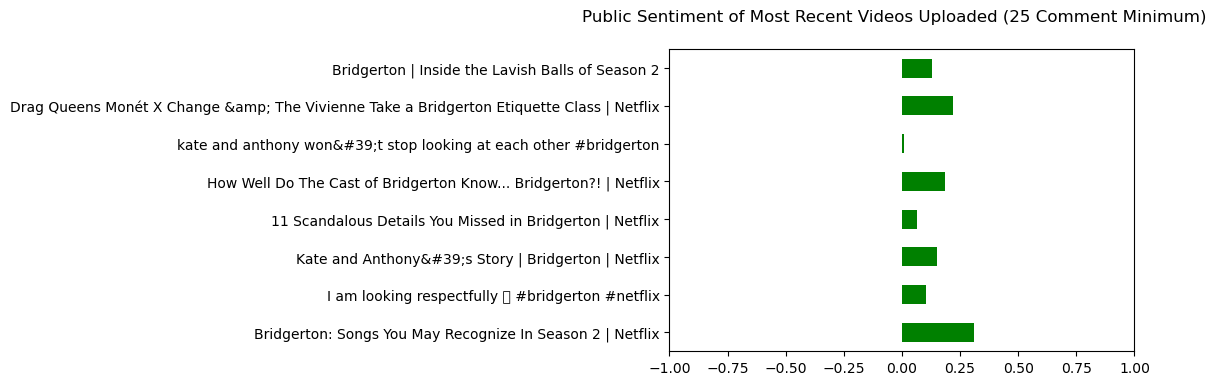

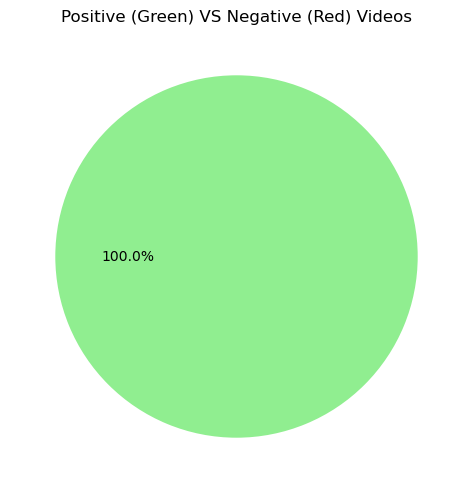

In [4]:
# Enter a channel ID and your desired number of most recent videos.
channel_analyzer(channel_id='UCGie8GMlUo3kBKIopdvumVQ', num_videos=8)